# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import RFE

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [3]:
#churn = churn.dropna()

### One hot encoding

In [4]:
churnAnalysis = churn.drop(["CFU", "BYO_PLAN_STATUS", "CONTRACT_STATUS", "CUST_ID", "COUNTRY_METRO_REGION", "STATE", "RECON_TELE_NEXT_MTH", "RECON_EMAIL_NEXT_MTH", "RECON_SMS_NEXT_MTH", "HANDSET_USED_BRAND"], axis=1)


In [5]:

#churnAnalysis = churnAnalysis.append(pd.get_dummies(churn["CONTRACT_STATUS"], dummy_na=False))

In [6]:
#churnAnalysis = churn[["ACCOUNT_TENURE", "ACCT_CNT_SERVICES", "AGE", "SERVICE_TENURE", "PLAN_ACCESS_FEE", "PLAN_TENURE", #"MONTHS_OF_CONTRACT_REMAINING"
#                       "PREV_CONTRACT_DURATION", "MONTHLY_SPEND", "CHURN_IND"]]
#churnAnalysis = churn.drop(["CFU", "BYO_PLAN_STATUS", "UNKNOWN", "CONTRACT_STATUS", "CUST_ID", "HANDSET_USED_BRAND", "COUNTRY_METRO_REGION", "STATE", "RECON_TELE_NEXT_MTH", "RECON_EMAIL_NEXT_MTH"], axis = 1)
#churnAnalysis = churnAnalysis.fillna(0)
#churnAnalysis

In [7]:
chunrnAnalysis = churnAnalysis.dropna(how='any', inplace=True)
churnAnalysis = churnAnalysis.join(pd.get_dummies(churn["HANDSET_USED_BRAND"], dummy_na=False))
#churnAnalysis["CHURN_IND"].mean()


In [8]:
train, test = train_test_split(churnAnalysis, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(36904, 17)
(9226, 17)


In [9]:
X_train = train.drop(['CHURN_IND'], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND'], axis=1)
y_test = test['CHURN_IND']


lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [11]:
print("Train Accuracy: ")
print(accuracy_score(y_train, train_preds))
print("Test Accuracy: ")
print(accuracy_score(y_test, test_preds))

Train Accuracy: 
0.7097333622371559
Test Accuracy: 
0.7085410795577716


Train Confusion Matrix: 


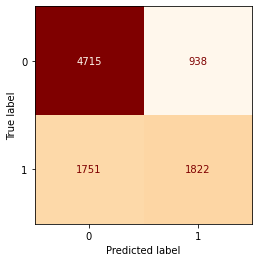

In [12]:
print("Train Confusion Matrix: ")
plot_confusion_matrix(lr, X_test, y_test, cmap="OrRd", colorbar = False)

In [13]:
lr = LogisticRegression()
rfe = RFE(estimator = lr, n_features_to_select = 5, step=1)
rfe.fit(X_train, y_train)

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [14]:
X_train.columns[rfe.support_]

Index(['APPLE', 'GOOGLE', 'OTHER', 'SAMSUNG', 'UNKNOWN'], dtype='object')

In [15]:
train_rfe_preds = rfe.predict(X_train)
test_rfe_preds = rfe.predict(X_test)
print("Train Accuracy: ")
print(accuracy_score(y_train, train_rfe_preds))
print("Test Accuracy: ")
print(accuracy_score(y_test, test_rfe_preds))

Train Accuracy: 
0.6240244959895946
Test Accuracy: 
0.6236722306525038


In [16]:
train_accuracies = []
test_accuracies = []
for i in range(1, X_train.shape[1]+1):
    lr = LogisticRegression()
    rfe = RFE(estimator = lr, n_features_to_select = i, step=1)
    rfe.fit(X_train, y_train)
    train_rfe_preds = rfe.predict(X_train)
    test_rfe_preds = rfe.predict(X_test)
    
    train_accuracies.append(accuracy_score(y_train, train_rfe_preds))
    test_accuracies.append(accuracy_score(y_test, test_rfe_preds))

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Text(0, 0.5, 'Accuracy')

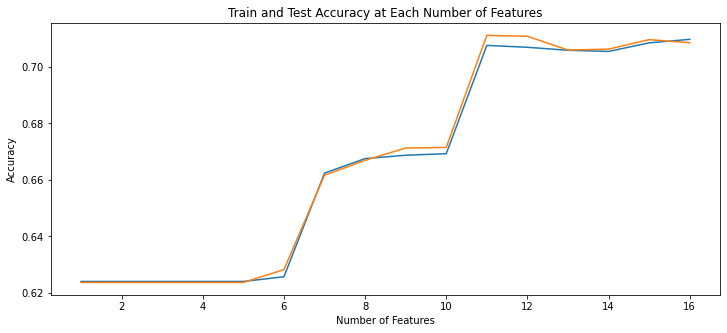

In [17]:
plt.figure(figsize=(12,5))
plt.plot(range(1, X_train.shape[1]+1), train_accuracies)
plt.plot(range(1, X_train.shape[1]+1), test_accuracies)
plt.title("Train and Test Accuracy at Each Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")

In [18]:
lr = LogisticRegression()
rfe = RFE(estimator = lr, n_features_to_select = 1, step=1)
rfe.fit(X_train, y_train)
print("The most important value for this model is: ")
print(X_train.columns[rfe.support_])

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

The most important value for this model is: 
Index(['UNKNOWN'], dtype='object')
